36
(2, 2)


c:\Users\CYTech Student\workspace\PuboOnSqArea.py:486: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(["SA 1000 iter 50"])


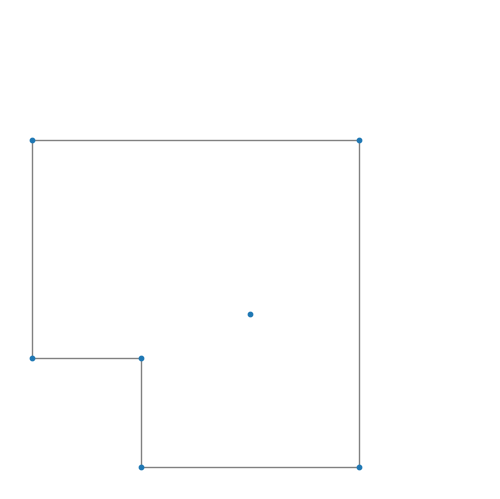

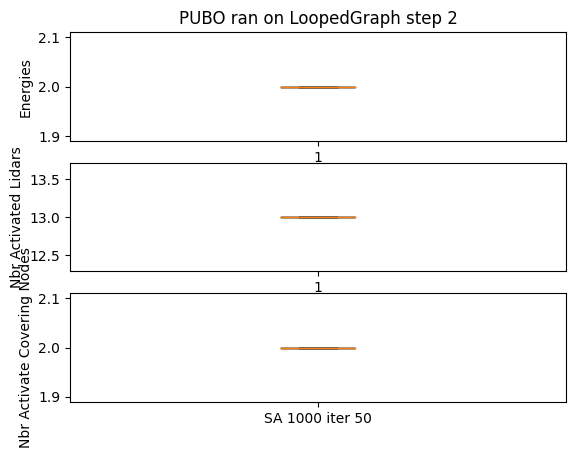

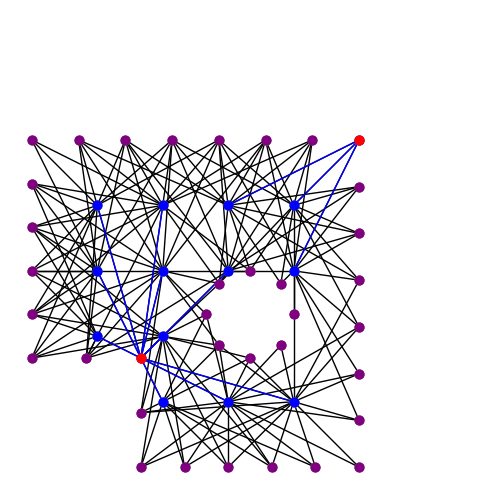

<Figure size 640x480 with 0 Axes>

In [1]:
# from PuboOnGraph import Graph,listLidar,listCovering*
from PuboOnSqArea import Graph,listPositionLidar as listLidar,listCovering
pointsL = listLidar
points3 = listCovering
G = Graph

import os
from platform import node
import numpy as np
import qiskit_optimization
from docplex.mp.model import Model
from qiskit_optimization.problems import QuadraticProgram
import networkx as nx
import re


In [2]:
m = Model(name='BMW') 

x = m.binary_var_dict(pointsL, name='x')
m.objective_expr = sum(x[i] for i in pointsL)
m.objective_sense = 'min'

for node in points3:
    m.add_constraint(1 == sum(x[v] for v in G.neighbors(node)))

m.export_as_lp(basename="Equal", path=os.path.abspath(""))

'c:\\Users\\CYTech Student\\workspace\\Equal.lp'

In [3]:
m = Model(name='BMW') 

x = m.binary_var_dict(pointsL, name='x')
m.objective_expr = sum(x[i] for i in pointsL)
m.objective_sense = 'min'

for node in points3:
    m.add_constraint(1 <= sum(x[v] for v in G.neighbors(node)))

m.export_as_lp(basename="Inequal", path=os.path.abspath(""))

'c:\\Users\\CYTech Student\\workspace\\Inequal.lp'

In [4]:
m = Model(name='BMW') 

x = m.binary_var_dict(pointsL, name='x')
m.objective_expr = sum(x[i] for i in pointsL)
m.objective_sense = 'min'

y = {node:m.binary_var_list(G.degree(node), name='z_'+str(node)) for node in points3}
for node in points3:
    m.add_constraint(sum(y[node]) >= 1)

for node in points3:
    m.add_constraint(sum(y[node]) == sum(x[v] for v in G.neighbors(node)))

m.export_as_lp(basename="JR", path=os.path.abspath(""))

'c:\\Users\\CYTech Student\\workspace\\JR.lp'

In [5]:
m = Model(name='BMW') 

x = m.binary_var_dict(pointsL, name='x')
m.objective_expr = sum(x[i] for i in pointsL)
m.objective_sense = 'min'

ub = []
for node in points3:
    ub.append(G.degree[node])

y = m.integer_var_dict(points3, name='y',lb=1, ub=ub)

for node in points3:
    m.add_constraint(y[node] == sum(x[v] for v in G.neighbors(node)))

m.export_as_lp(basename="JS", path=os.path.abspath(""))

'c:\\Users\\CYTech Student\\workspace\\JS.lp'

In [6]:
m = Model(name='BMW')
x = m.binary_var_dict(pointsL, name='x')
m.objective_expr = sum(x[i] for i in pointsL) #minimize the placement of lidars
m.objective_sense = 'min'

y = m.binary_var_dict(G.edges, name='y')

#constraint on edge covering all vertices (allows to ensure that at least one lidar covers the area)
for node in points3:
  var =[]
  for i in G.edges(node):
    if i in y:
      var.append(y[i])
    elif (i[1], i[0]) in y:
      var.append(y[i[1],i[0]])
  m.add_constraint(sum(var) >= 1)

#Link the relation between edge activation and lidar placement activation

for node in pointsL:
  var =[]
  for i in G.edges(node):
    if i[0] == node:
      if i in y:
        var.append(y[i]- x[node])
      elif (i[1], i[0]) in y:
        var.append(y[i[1],i[0]]- x[node])
    m.add_constraint(sum(var) == 0)

m.export_as_lp(basename="RR", path=os.path.abspath(""))

'c:\\Users\\CYTech Student\\workspace\\RR.lp'

In [7]:
listQUBO = []
QUBONames = ["RR","JS","JR","Equal","Inequal"]
for i in range (0, 5):
    quadratic_program = QuadraticProgram()
    quadratic_program.read_from_lp_file(QUBONames[i]+'.lp')

    from qiskit_optimization import QuadraticProgram
    from qiskit_optimization.converters import QuadraticProgramToQubo
    import math
    # qubo conversion
    conv = QuadraticProgramToQubo()

    qp = conv.convert(quadratic_program)
    listQUBO.append(qp)

Number of vertices :  49
Number of edges :  168
RR  :  289
JS  :  100
JR  :  289
Equal  :  49
Inequal  :  100


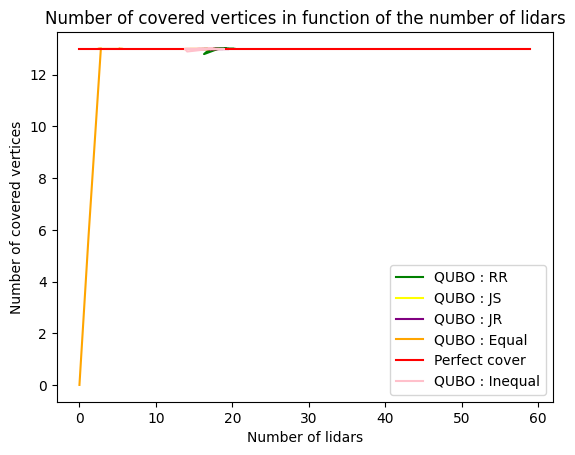

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import neal
import greedy

from PuboOnSqArea import Graph,listCovering,listLidar

print("Number of vertices : ", len(Graph.nodes))
print("Number of edges : ", len(Graph.edges))
colors = ["green", "yellow", "purple", "orange", "pink"]
for idqb,qp in enumerate(listQUBO):
    step_coeff= 0
    covered = []
    nb_lidars = []
    res = []
    while step_coeff < 2.5:
        covereds = []
        nb_lidarss = []
        ress = []
        matrice = qp.objective.quadratic.coefficients.asformat("array")
        if step_coeff==0:
            print(QUBONames[idqb], " : ",int(math.sqrt(len(matrice))+1)**2)
        diagonal = qp.objective.linear.coefficients.asformat("array")*step_coeff

        # Add a x1.3 factor to the factors linked to the constraint


        for i in range (len(matrice)):
            for j in range(len(matrice[i])):
                if j == i:
                    matrice[i][j] += diagonal[0][j]
                    
        for k in range(10):
            matrice2 = np.zeros((int(math.sqrt(len(matrice))+1)**2,int(math.sqrt(len(matrice))+1)**2))
            matrice2[:len(matrice),:len(matrice)] = matrice

            pointsL = listLidar
            points3 = listCovering

            sampler = neal.SimulatedAnnealingSampler()

            sampleset = sampler.sample_qubo(matrice2,
                                            num_reads=10,
                                            chain_strength=3,
                                            
                                        )


            f = list(sampleset.first.sample.values())
            S = []
            for i,x in enumerate(pointsL):
                if f[i]:
                    S.append((x[0], x[1]))
            listCoverN = []
            for node in S:
                for node2 in Graph.neighbors(node):
                    if node2 not in listCoverN:
                        listCoverN.append(node2)
            covereds.append(len(listCoverN))
            nb_lidarss.append(len(S))
            ress.append(len(listCoverN)-len(S))
        covered.append(np.array(covereds).mean())
        nb_lidars.append(np.array(nb_lidarss).mean())
        res.append(np.array(ress).mean())
        step_coeff += 0.1
    
    plt.plot(nb_lidars, covered, label = "QUBO : " + QUBONames[idqb],color=colors[idqb])
    if QUBONames[idqb] == "Equal":
        plt.plot(list(range(60)), [len(points3) for i in range(60)], color = "red", label = "Perfect cover")

    # legend with qubo names and colors
    plt.legend()
    
plt.title("Number of covered vertices in function of the number of lidars")

# plt.xlim(20, 45)
# plt.ylim(80, 120)

plt.xlabel("Number of lidars")
plt.ylabel("Number of covered vertices")
plt.show()